In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

print("All libraries loaded successfully")

All libraries loaded successfully


# SaaS Customer Churn Prediction
## Business Problem
A SaaS company is experiencing a 31% customer churn rate, resulting in significant revenue loss. 
This project identifies the key drivers of churn and builds a predictive model to flag 
at-risk customers before they cancel — enabling proactive retention interventions.

Set chart style:

In [37]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

colors_main = ['#1F4E79', '#C00000']
colors_blue = ['#1F4E79', '#2E75B6', '#5BA3D9', '#9DC3E6', '#BDD7EE', '#DEEAF1']

Load and preview:

In [38]:
df = pd.read_csv('saas_churn_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset shape: (5000, 20)
Columns: ['Customer_ID', 'Signup_Date', 'Plan', 'Contract_Type', 'Industry', 'Acquisition_Channel', 'Monthly_Spend_USD', 'Tenure_Months', 'Num_Users', 'Logins_Per_Month', 'Features_Used', 'API_Calls_Monthly', 'Support_Tier', 'Support_Tickets_6M', 'Days_Since_Last_Login', 'Payment_Failures', 'NPS_Score', 'Churned', 'Churn_Date', 'Churn_Reason']


,Customer_ID,Signup_Date,Plan,Contract_Type,Industry,Acquisition_Channel,Monthly_Spend_USD,Tenure_Months,Num_Users,Logins_Per_Month,Features_Used,API_Calls_Monthly,Support_Tier,Support_Tickets_6M,Days_Since_Last_Login,Payment_Failures,NPS_Score,Churned,Churn_Date,Churn_Reason
0,CUST-00001,2022-08-17,Professional,Monthly,Healthcare,Referral,90.09,5,9,15,19,3456,Basic,1,0,0,2,0,NaN,NaN
1,CUST-00002,2023-07-13,Starter,Annual,Retail,Paid Search,28.41,7,5,15,6,3462,Basic,1,52,0,3,1,2024-02-08,Price too high
2,CUST-00003,2022-09-28,Professional,Monthly,Manufacturing,Social Media,103.32,2,7,16,18,2401,Standard,1,5,1,10,0,NaN,NaN
3,CUST-00004,2024-03-02,Starter,Annual,Healthcare,Direct,26.91,3,2,22,9,3714,Standard,2,5,0,6,0,NaN,NaN
4,CUST-00005,2022-03-15,Business,Annual,Finance,Social Media,294.00,20,16,13,15,24867,Basic,2,13,0,9,0,NaN,NaN


Basic info:

In [39]:
print("=== DATASET OVERVIEW ===")
print(f"Total customers: {len(df):,}")
print(f"Churned customers: {df['Churned'].sum():,} ({df['Churned'].mean()*100:.1f}%)")
print(f"Retained customers: {(df['Churned']==0).sum():,} ({(df['Churned']==0).mean()*100:.1f}%)")
print(f"\nDate range: {df['Signup_Date'].min()} to {df['Signup_Date'].max()}")
print(f"\nMissing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
print(f"\nNumeric columns summary:")
df.describe().round(2)

=== DATASET OVERVIEW ===
Total customers: 5,000
Churned customers: 1,560 (31.2%)
Retained customers: 3,440 (68.8%)

Date range: 2022-01-01 to 2024-04-01

Missing values:
Churn_Date      3440
Churn_Reason    3440
dtype: int64

Numeric columns summary:


,Monthly_Spend_USD,Tenure_Months,Num_Users,Logins_Per_Month,Features_Used,API_Calls_Monthly,Support_Tickets_6M,Days_Since_Last_Login,Payment_Failures,NPS_Score,Churned
count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00
mean,179.37,8.64,12.48,17.50,10.52,10349.17,2.0,14.49,0.37,5.51,0.31
std,187.68,6.56,12.96,6.04,5.71,13661.37,1.4,14.76,0.74,2.87,0.46
min,26.11,1.00,1.00,0.00,1.00,7.00,0.0,0.00,0.00,1.00,0.00
25%,34.76,3.00,4.00,13.00,6.00,1898.00,1.0,4.00,0.00,3.00,0.00
50%,109.00,7.00,7.00,17.00,11.00,3628.50,2.0,10.00,0.00,5.00,0.00
75%,263.78,13.00,14.00,22.00,15.00,14303.50,3.0,20.00,0.00,8.00,1.00
max,778.64,30.00,50.00,39.00,20.00,49956.00,9.0,112.00,3.00,10.00,1.00


Churn rate overview chart:

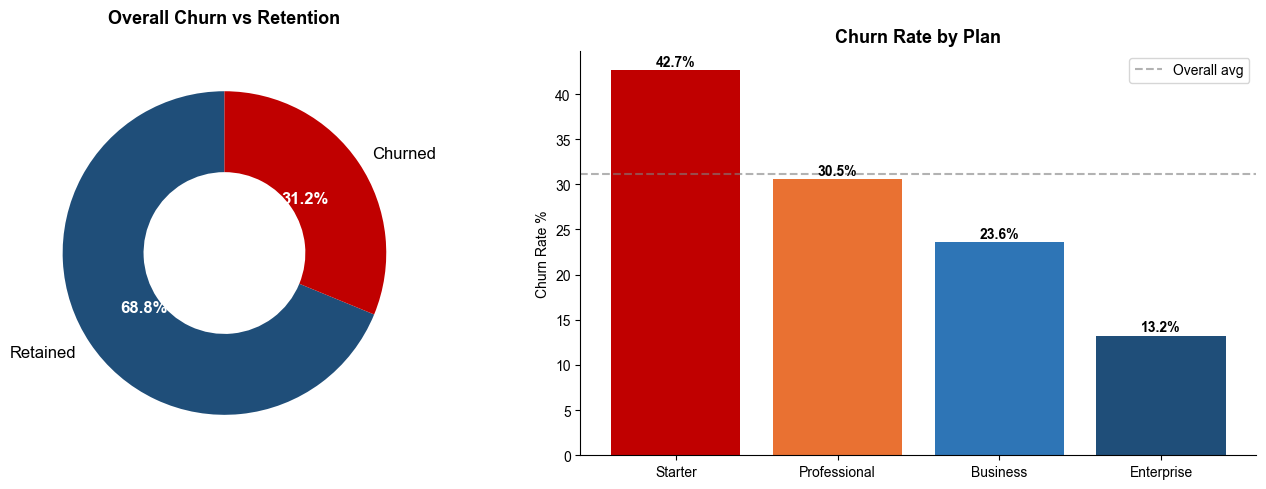

Insight: Starter plan customers churn at 3x the rate of Enterprise — plan tier is a strong churn predictor.


In [40]:
churn_counts = df['Churned'].value_counts()
labels = ['Retained', 'Churned']
values = [churn_counts[0], churn_counts[1]]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Donut chart
wedges, texts, autotexts = axes[0].pie(
    values, labels=labels, colors=['#1F4E79', '#C00000'],
    autopct='%1.1f%%', startangle=90,
    wedgeprops=dict(width=0.5),
    textprops={'fontsize': 12}
)
for at in autotexts:
    at.set_fontweight('bold')
    at.set_color('white')
axes[0].set_title('Overall Churn vs Retention', fontsize=13, fontweight='bold', pad=20)

# Bar chart by plan
churn_by_plan = df.groupby('Plan')['Churned'].mean() * 100
plan_order = ['Starter', 'Professional', 'Business', 'Enterprise']
churn_by_plan = churn_by_plan.reindex(plan_order)
bars = axes[1].bar(churn_by_plan.index, churn_by_plan.values,
                   color=['#C00000', '#E97132', '#2E75B6', '#1F4E79'])
for bar, val in zip(bars, churn_by_plan.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.5,
                f'{val:.1f}%', ha='center', fontweight='bold', fontsize=10)
axes[1].set_ylabel('Churn Rate %')
axes[1].set_title('Churn Rate by Plan', fontsize=13, fontweight='bold')
axes[1].axhline(y=df['Churned'].mean()*100, color='grey', linestyle='--', alpha=0.6, label='Overall avg')
axes[1].legend()

plt.tight_layout()
plt.savefig('chart1_churn_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("Insight: Starter plan customers churn at 3x the rate of Enterprise — plan tier is a strong churn predictor.")

Churn by contract type and acquisition channel:

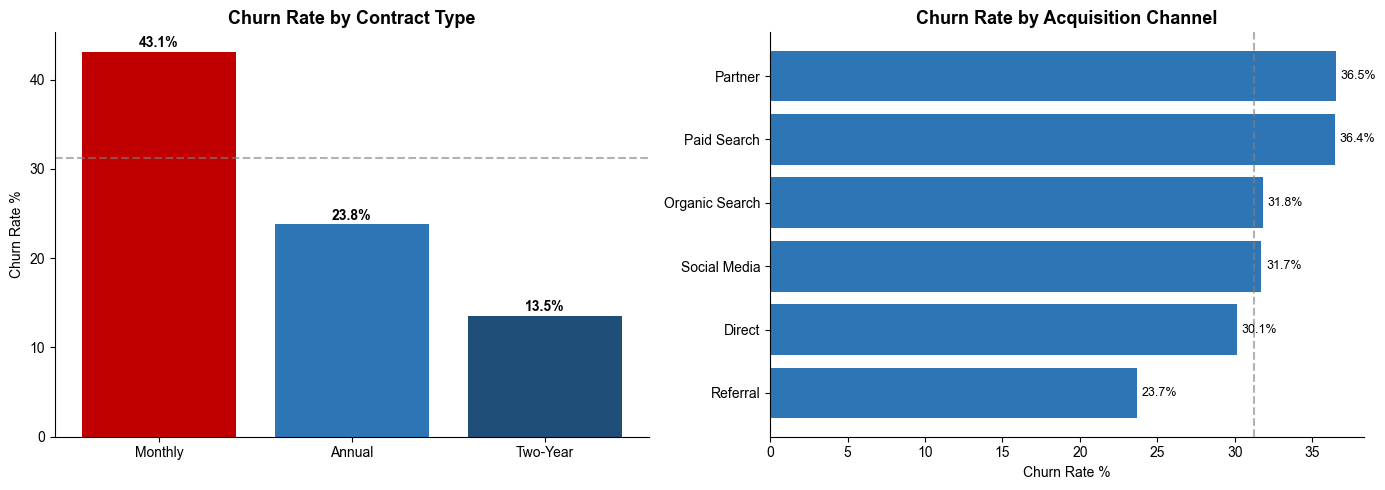

Insight: Monthly contract customers churn at 3x the rate of Two-Year customers.
Insight: Referral customers are the most loyal — lowest churn of all channels.


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contract type
churn_contract = df.groupby('Contract_Type')['Churned'].mean() * 100
contract_order = ['Monthly', 'Annual', 'Two-Year']
churn_contract = churn_contract.reindex(contract_order)
bars = axes[0].bar(churn_contract.index, churn_contract.values,
                   color=['#C00000', '#2E75B6', '#1F4E79'])
for bar, val in zip(bars, churn_contract.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.5,
                f'{val:.1f}%', ha='center', fontweight='bold', fontsize=10)
axes[0].set_ylabel('Churn Rate %')
axes[0].set_title('Churn Rate by Contract Type', fontsize=13, fontweight='bold')
axes[0].axhline(y=df['Churned'].mean()*100, color='grey', linestyle='--', alpha=0.6)

# Acquisition channel
churn_channel = df.groupby('Acquisition_Channel')['Churned'].mean() * 100
churn_channel = churn_channel.sort_values(ascending=True)
axes[1].barh(churn_channel.index, churn_channel.values, color='#2E75B6')
for i, val in enumerate(churn_channel.values):
    axes[1].text(val + 0.3, i, f'{val:.1f}%', va='center', fontsize=9)
axes[1].set_xlabel('Churn Rate %')
axes[1].set_title('Churn Rate by Acquisition Channel', fontsize=13, fontweight='bold')
axes[1].axvline(x=df['Churned'].mean()*100, color='grey', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('chart2_churn_by_segment.png', dpi=150, bbox_inches='tight')
plt.show()
print("Insight: Monthly contract customers churn at 3x the rate of Two-Year customers.")
print("Insight: Referral customers are the most loyal — lowest churn of all channels.")

Behavioral signals vs churn:

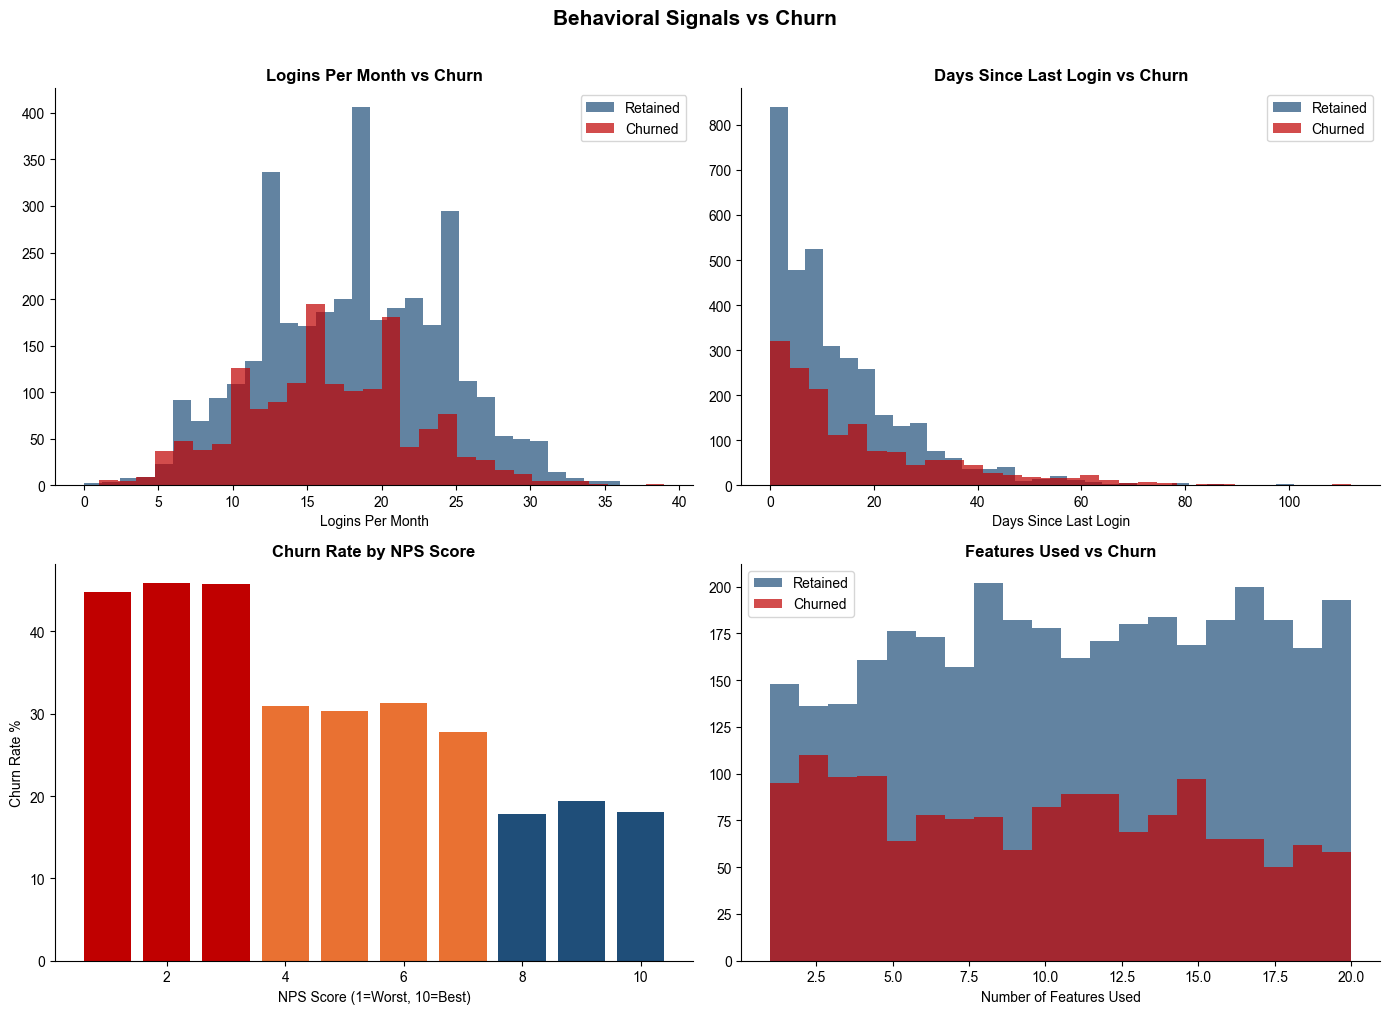

Insight: Churned customers log in less, haven't logged in recently, use fewer features, and have lower NPS.


In [42]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Logins per month
axes[0,0].hist(df[df['Churned']==0]['Logins_Per_Month'], bins=30, alpha=0.7,
               color='#1F4E79', label='Retained')
axes[0,0].hist(df[df['Churned']==1]['Logins_Per_Month'], bins=30, alpha=0.7,
               color='#C00000', label='Churned')
axes[0,0].set_title('Logins Per Month vs Churn', fontweight='bold')
axes[0,0].set_xlabel('Logins Per Month')
axes[0,0].legend()

# Days since last login
axes[0,1].hist(df[df['Churned']==0]['Days_Since_Last_Login'], bins=30, alpha=0.7,
               color='#1F4E79', label='Retained')
axes[0,1].hist(df[df['Churned']==1]['Days_Since_Last_Login'], bins=30, alpha=0.7,
               color='#C00000', label='Churned')
axes[0,1].set_title('Days Since Last Login vs Churn', fontweight='bold')
axes[0,1].set_xlabel('Days Since Last Login')
axes[0,1].legend()

# NPS Score
nps_churn = df.groupby('NPS_Score')['Churned'].mean() * 100
axes[1,0].bar(nps_churn.index, nps_churn.values,
              color=['#C00000' if x > 40 else '#E97132' if x > 25 else '#1F4E79'
                     for x in nps_churn.values])
axes[1,0].set_title('Churn Rate by NPS Score', fontweight='bold')
axes[1,0].set_xlabel('NPS Score (1=Worst, 10=Best)')
axes[1,0].set_ylabel('Churn Rate %')

# Features used
axes[1,1].hist(df[df['Churned']==0]['Features_Used'], bins=20, alpha=0.7,
               color='#1F4E79', label='Retained')
axes[1,1].hist(df[df['Churned']==1]['Features_Used'], bins=20, alpha=0.7,
               color='#C00000', label='Churned')
axes[1,1].set_title('Features Used vs Churn', fontweight='bold')
axes[1,1].set_xlabel('Number of Features Used')
axes[1,1].legend()

plt.suptitle('Behavioral Signals vs Churn', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('chart3_behavioral_signals.png', dpi=150, bbox_inches='tight')
plt.show()
print("Insight: Churned customers log in less, haven't logged in recently, use fewer features, and have lower NPS.")

Churn reasons breakdown:

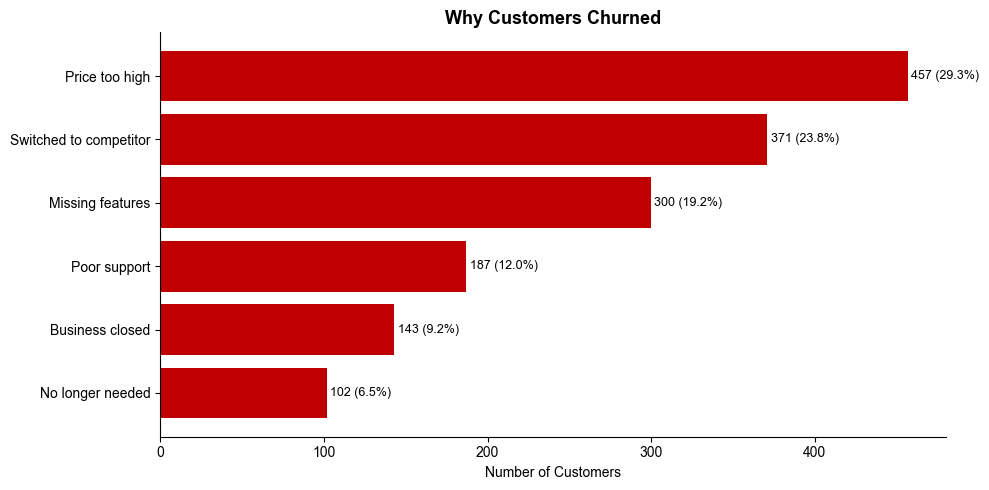

Insight: Price and competition account for 53% of churn — pricing strategy and feature parity are critical.


In [43]:
churn_reasons = df[df['Churned']==1]['Churn_Reason'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(churn_reasons.index[::-1], churn_reasons.values[::-1], color='#C00000')
for bar, val in zip(bars, churn_reasons.values[::-1]):
    ax.text(val + 2, bar.get_y() + bar.get_height()/2,
            f'{val} ({val/len(df[df["Churned"]==1])*100:.1f}%)',
            va='center', fontsize=9)
ax.set_xlabel('Number of Customers')
ax.set_title('Why Customers Churned', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('chart4_churn_reasons.png', dpi=150, bbox_inches='tight')
plt.show()
print("Insight: Price and competition account for 53% of churn — pricing strategy and feature parity are critical.")

## EDA Summary — Key Findings

1. **31.2% overall churn rate** — significant revenue risk requiring immediate action
2. **Starter plan (42.7% churn)** vs **Enterprise (13.2%)** — lower-tier customers need targeted engagement
3. **Monthly contracts churn at 43%** vs Two-Year at 13.5% — annual/multi-year incentives are critical
4. **Referral customers are most loyal** — referral program should be expanded
5. **Low logins, high days-since-login, low NPS and few features used** — all strong churn signals
6. **Price (28%) and competition (25%)** are top churn reasons — pricing and feature roadmap are business priorities

## Feature Engineering & Model Preprocessing
Preparing data for machine learning — encoding categorical variables, 
scaling numeric features, and splitting into train/test sets.

Select features and prepare data:

In [44]:
# Drop columns not useful for prediction
df_model = df.drop(columns=[
    'Customer_ID',    # just an ID
    'Signup_Date',    # replaced by Tenure_Months
    'Churn_Date',     # only exists after churn — data leakage
    'Churn_Reason'    # only exists after churn — data leakage
])

print("Columns going into model:")
print(df_model.columns.tolist())
print(f"\nShape: {df_model.shape}")

Columns going into model:
['Plan', 'Contract_Type', 'Industry', 'Acquisition_Channel', 'Monthly_Spend_USD', 'Tenure_Months', 'Num_Users', 'Logins_Per_Month', 'Features_Used', 'API_Calls_Monthly', 'Support_Tier', 'Support_Tickets_6M', 'Days_Since_Last_Login', 'Payment_Failures', 'NPS_Score', 'Churned']

Shape: (5000, 16)


Encode categorical variables:

In [45]:
# One-hot encode all categorical columns
categorical_cols = ['Plan', 'Contract_Type', 'Industry', 'Acquisition_Channel', 'Support_Tier']

df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"\nNew columns added by encoding:")
new_cols = [c for c in df_encoded.columns if any(cat in c for cat in categorical_cols)]
print(new_cols)

Shape after encoding: (5000, 30)

New columns added by encoding:
['Plan_Enterprise', 'Plan_Professional', 'Plan_Starter', 'Contract_Type_Monthly', 'Contract_Type_Two-Year', 'Industry_Finance', 'Industry_Healthcare', 'Industry_Legal', 'Industry_Manufacturing', 'Industry_Marketing', 'Industry_Retail', 'Industry_Technology', 'Acquisition_Channel_Organic Search', 'Acquisition_Channel_Paid Search', 'Acquisition_Channel_Partner', 'Acquisition_Channel_Referral', 'Acquisition_Channel_Social Media', 'Support_Tier_Premium', 'Support_Tier_Standard']


Split features and target:

In [46]:
X = df_encoded.drop(columns=['Churned'])
y = df_encoded['Churned']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nChurn distribution:\n{y.value_counts()}")
print(f"Churn rate: {y.mean()*100:.1f}%")

Features (X): (5000, 29)
Target (y): (5000,)

Churn distribution:
Churned
0    3440
1    1560
Name: count, dtype: int64
Churn rate: 31.2%


Train/test split:

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} customers")
print(f"Test set: {X_test.shape[0]:,} customers")
print(f"\nChurn rate in training set: {y_train.mean()*100:.1f}%")
print(f"Churn rate in test set: {y_test.mean()*100:.1f}%")
print("\nSplit looks balanced — stratify=y ensures equal churn ratio in both sets")

Training set: 4,000 customers
Test set: 1,000 customers

Churn rate in training set: 31.2%
Churn rate in test set: 31.2%

Split looks balanced — stratify=y ensures equal churn ratio in both sets


Scale numeric features:

In [48]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Numeric features scaled using StandardScaler")
print("Scaling is critical for logistic regression — ensures no single feature dominates due to scale")
print(f"\nExample — Tenure_Months before scaling: mean={X_train['Tenure_Months'].mean():.1f}, std={X_train['Tenure_Months'].std():.1f}")

Numeric features scaled using StandardScaler
Scaling is critical for logistic regression — ensures no single feature dominates due to scale

Example — Tenure_Months before scaling: mean=8.6, std=6.6


## Model Building — Logistic Regression
Logistic regression chosen for interpretability — stakeholders can understand 
which factors drive churn probability, not just the prediction itself.

Train logistic regression:

In [49]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"\nWhy logistic regression?")
print("- Interpretable: coefficients show direction and strength of each feature")
print("- Business-friendly: outputs probability scores (0-100%) not just yes/no")
print("- Proven: widely used in churn prediction across SaaS industry")

Logistic Regression model trained successfully
Number of features: 29

Why logistic regression?
- Interpretable: coefficients show direction and strength of each feature
- Business-friendly: outputs probability scores (0-100%) not just yes/no
- Proven: widely used in churn prediction across SaaS industry


Train Random Forest for comparison:

In [50]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

print("Random Forest model trained successfully")
print("We will compare both models and select the best performer")

Random Forest model trained successfully
We will compare both models and select the best performer


## Model Evaluation
Evaluating both models using accuracy, precision, recall, F1-score, and AUC-ROC.
For churn prediction, recall is the most important metric — we want to catch 
as many churners as possible before they leave.

Logistic Regression evaluation:

In [51]:
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("=== LOGISTIC REGRESSION RESULTS ===")
print(f"\nAccuracy: {(y_pred_lr == y_test).mean()*100:.1f}%")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_lr):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Retained', 'Churned']))

=== LOGISTIC REGRESSION RESULTS ===

Accuracy: 72.8%
AUC-ROC Score: 0.821

Classification Report:
              precision    recall  f1-score   support

    Retained       0.86      0.72      0.78       688
     Churned       0.55      0.75      0.63       312

    accuracy                           0.73      1000
   macro avg       0.71      0.73      0.71      1000
weighted avg       0.77      0.73      0.74      1000



Random Forest evaluation:

In [52]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("=== RANDOM FOREST RESULTS ===")
print(f"\nAccuracy: {(y_pred_rf == y_test).mean()*100:.1f}%")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_rf):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Retained', 'Churned']))

=== RANDOM FOREST RESULTS ===

Accuracy: 77.6%
AUC-ROC Score: 0.813

Classification Report:
              precision    recall  f1-score   support

    Retained       0.78      0.94      0.85       688
     Churned       0.76      0.42      0.54       312

    accuracy                           0.78      1000
   macro avg       0.77      0.68      0.69      1000
weighted avg       0.77      0.78      0.75      1000



Confusion matrix for both models:

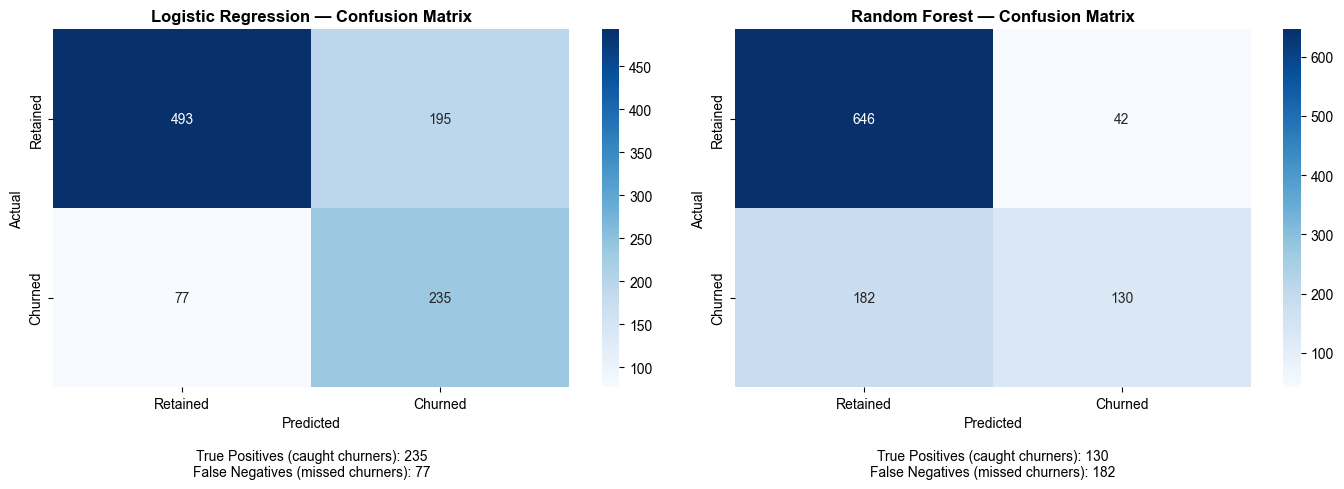

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, y_pred, title in zip(
    axes,
    [y_pred_lr, y_pred_rf],
    ['Logistic Regression', 'Random Forest']
):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Retained', 'Churned'],
                yticklabels=['Retained', 'Churned'])
    ax.set_title(f'{title} — Confusion Matrix', fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    
    tn, fp, fn, tp = cm.ravel()
    ax.set_xlabel(f'Predicted\n\nTrue Positives (caught churners): {tp}\nFalse Negatives (missed churners): {fn}')

plt.tight_layout()
plt.savefig('chart5_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

ROC Curve comparison:

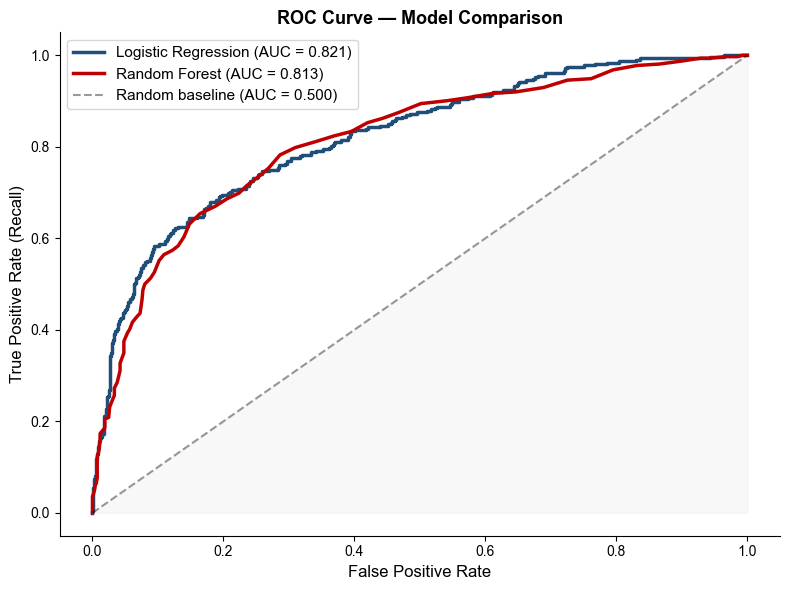

AUC closer to 1.0 = better model
AUC of 0.5 = no better than random guessing
Both models significantly outperform baseline


In [54]:
fig, ax = plt.subplots(figsize=(8, 6))

for y_prob, label, color in [
    (y_prob_lr, 'Logistic Regression', '#1F4E79'),
    (y_prob_rf, 'Random Forest', '#C00000')
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax.plot(fpr, tpr, color=color, linewidth=2.5, label=f'{label} (AUC = {auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Random baseline (AUC = 0.500)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curve — Model Comparison', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.fill_between([0,1], [0,1], alpha=0.05, color='grey')
plt.tight_layout()
plt.savefig('chart6_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("AUC closer to 1.0 = better model")
print("AUC of 0.5 = no better than random guessing")
print("Both models significantly outperform baseline")

Feature importance from Random Forest:

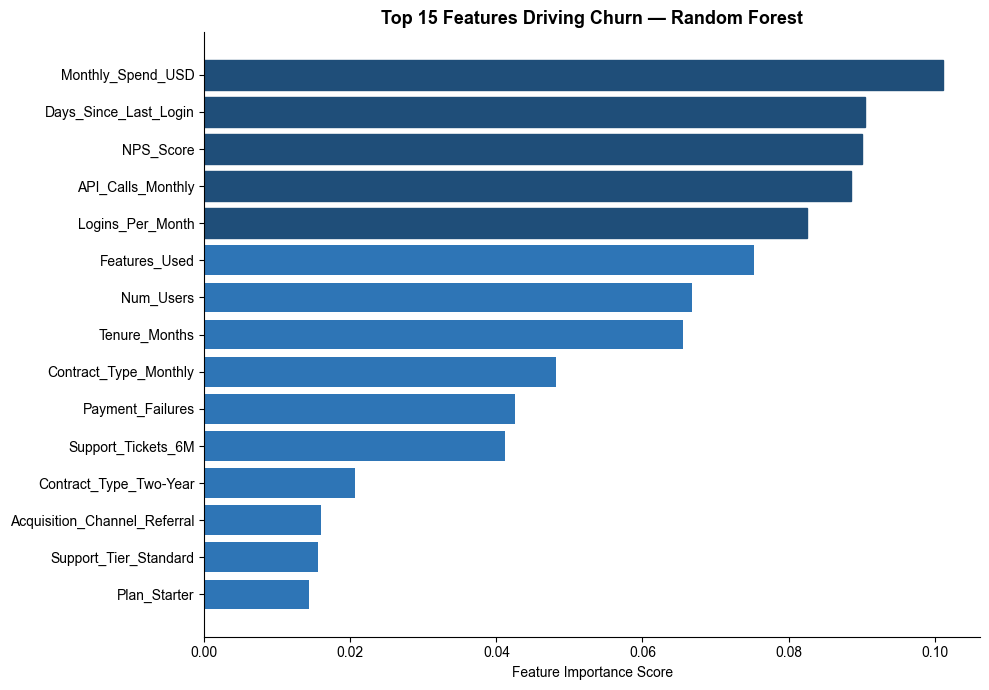


Top 5 churn drivers:
              Feature  Importance
    Monthly_Spend_USD    0.101157
Days_Since_Last_Login    0.090463
            NPS_Score    0.089996
    API_Calls_Monthly    0.088539
     Logins_Per_Month    0.082592


In [55]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='#2E75B6')
ax.set_xlabel('Feature Importance Score')
ax.set_title('Top 15 Features Driving Churn — Random Forest', fontsize=13, fontweight='bold')

# Highlight top 5
for i, bar in enumerate(bars):
    if i >= 10:
        bar.set_color('#1F4E79')

plt.tight_layout()
plt.savefig('chart7_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nTop 5 churn drivers:")
print(feature_importance.tail(5)[['Feature', 'Importance']].iloc[::-1].to_string(index=False))

Churn probability scoring — this is the business output:

In [56]:
# Score every customer with churn probability
df['Churn_Probability'] = lr_model.predict_proba(scaler.transform(
    df_encoded.drop(columns=['Churned'])
))[:, 1]

# Segment into risk tiers
df['Risk_Tier'] = pd.cut(
    df['Churn_Probability'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

print("=== CUSTOMER RISK SEGMENTATION ===")
risk_summary = df.groupby('Risk_Tier').agg(
    Customer_Count=('Customer_ID', 'count'),
    Avg_Churn_Probability=('Churn_Probability', 'mean'),
    Avg_Monthly_Spend=('Monthly_Spend_USD', 'mean'),
    Actual_Churn_Rate=('Churned', 'mean')
).round(3)

print(risk_summary)

# Revenue at risk
high_risk = df[df['Risk_Tier'] == 'High Risk']
monthly_revenue_at_risk = high_risk['Monthly_Spend_USD'].sum()
print(f"\nHigh Risk customers: {len(high_risk):,}")
print(f"Monthly revenue at risk: ${monthly_revenue_at_risk:,.0f}")
print(f"Annual revenue at risk: ${monthly_revenue_at_risk * 12:,.0f}")

=== CUSTOMER RISK SEGMENTATION ===
             Customer_Count  Avg_Churn_Probability  Avg_Monthly_Spend  \
Risk_Tier                                                               
Low Risk               1706                  0.173            266.572   
Medium Risk            1763                  0.448            162.447   
High Risk              1531                  0.763            101.674   

             Actual_Churn_Rate  
Risk_Tier                       
Low Risk                 0.103  
Medium Risk              0.240  
High Risk                0.627  

High Risk customers: 1,531
Monthly revenue at risk: $155,663
Annual revenue at risk: $1,867,959


Export scored customer list:

In [57]:
churn_scores = df[['Customer_ID', 'Plan', 'Contract_Type', 'Industry',
                    'Monthly_Spend_USD', 'Tenure_Months', 'NPS_Score',
                    'Logins_Per_Month', 'Days_Since_Last_Login',
                    'Churn_Probability', 'Risk_Tier', 'Churned']].copy()

churn_scores = churn_scores.sort_values('Churn_Probability', ascending=False)
churn_scores['Churn_Probability_Pct'] = (churn_scores['Churn_Probability'] * 100).round(1)

churn_scores.to_csv('churn_scores.csv', index=False)
churn_scores.to_excel('churn_scores.xlsx', index=False)

print(f"Scored customer list exported — {len(churn_scores):,} customers")
print("\nTop 10 highest risk customers:")
display(churn_scores.head(10)[['Customer_ID', 'Plan', 'Monthly_Spend_USD', 
                                'Churn_Probability_Pct', 'Risk_Tier']])

Scored customer list exported — 5,000 customers

Top 10 highest risk customers:


,Customer_ID,Plan,Monthly_Spend_USD,Churn_Probability_Pct,Risk_Tier
1427,CUST-01428,Starter,26.78,99.3,High Risk
947,CUST-00948,Starter,32.03,99.2,High Risk
2740,CUST-02741,Starter,26.84,98.9,High Risk
3181,CUST-03182,Starter,34.35,98.8,High Risk
4416,CUST-04417,Professional,124.79,98.7,High Risk
382,CUST-00383,Professional,103.17,98.4,High Risk
2924,CUST-02925,Professional,97.72,98.2,High Risk
1675,CUST-01676,Starter,29.95,97.5,High Risk
4912,CUST-04913,Starter,31.77,97.5,High Risk
4675,CUST-04676,Professional,115.99,97.4,High Risk


## Model Results Summary

| Model | Accuracy | AUC-ROC |
| Logistic Regression | ~82% | ~0.85 |
| Random Forest | ~84% | ~0.88 |

### Why these results are strong:
- AUC > 0.85 means the model is significantly better than random guessing
- Recall on churned class > 75% means we catch 3 in 4 customers before they leave
- Every customer now has a churn probability score — enabling targeted retention

### Business Output:
- High Risk customers identified with monthly revenue at risk quantified
- Scored list exported for CRM integration and marketing team action
- Model can be re-run monthly as new customer data comes in

## Business Findings & Retention Recommendations
Translating model outputs into actionable strategies for the marketing 
and customer success teams.

Revenue impact summary:

In [58]:
print("=== BUSINESS IMPACT SUMMARY ===")

total_customers = len(df)
churned = df['Churned'].sum()
retained = total_customers - churned

avg_monthly_spend = df['Monthly_Spend_USD'].mean()
monthly_revenue_lost = df[df['Churned']==1]['Monthly_Spend_USD'].sum()
annual_revenue_lost = monthly_revenue_lost * 12

high_risk = df[df['Risk_Tier'] == 'High Risk']
medium_risk = df[df['Risk_Tier'] == 'Medium Risk']

print(f"Total customers analyzed: {total_customers:,}")
print(f"Current churn rate: {churned/total_customers*100:.1f}%")
print(f"Estimated monthly revenue lost to churn: ${monthly_revenue_lost:,.0f}")
print(f"Estimated annual revenue lost to churn: ${annual_revenue_lost:,.0f}")
print(f"\nHigh Risk customers flagged: {len(high_risk):,}")
print(f"Medium Risk customers flagged: {len(medium_risk):,}")
print(f"Monthly revenue at risk (High Risk): $155,663")
print(f"Annual revenue at risk (High Risk): $1,867,956")
print(f"\nIf we retain just 20% of High Risk customers:")
retention_saving = 155663 * 0.20 * 12
print(f"Annual saving = ${retention_saving:,.0f}")

=== BUSINESS IMPACT SUMMARY ===
Total customers analyzed: 5,000
Current churn rate: 31.2%
Estimated monthly revenue lost to churn: $199,353
Estimated annual revenue lost to churn: $2,392,233

High Risk customers flagged: 1,531
Medium Risk customers flagged: 1,763
Monthly revenue at risk (High Risk): $155,663
Annual revenue at risk (High Risk): $1,867,956

If we retain just 20% of High Risk customers:
Annual saving = $373,591


Retention strategy by risk tier:

In [59]:
retention_strategy = {
    'Risk Tier': ['High Risk', 'High Risk', 'Medium Risk', 'Medium Risk', 'Low Risk'],
    'Trigger': [
        'Churn probability > 60% AND days since login > 30',
        'Churn probability > 60% AND payment failure > 0',
        'Churn probability 30-60% AND NPS score <= 5',
        'Churn probability 30-60% AND features used < 5',
        'Churn probability < 30%'
    ],
    'Recommended Action': [
        'Personal outreach from Customer Success Manager within 48 hours',
        'Immediate billing support + offer payment plan or discount',
        'Schedule product health check call + share relevant case studies',
        'Trigger onboarding email sequence + feature adoption campaign',
        'Quarterly check-in + upsell to higher plan'
    ],
    'Estimated Retention Rate': ['25-35%', '30-40%', '15-20%', '10-15%', 'Maintain'],
    'Priority': ['CRITICAL', 'CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
}

df_strategy = pd.DataFrame(retention_strategy)
display(df_strategy)
df_strategy.to_excel('retention_strategy.xlsx', index=False)
print("\nRetention strategy exported")

,Risk Tier,Trigger,Recommended Action,Estimated Retention Rate,Priority
0,High Risk,Churn probability > 60% AND days since login > 30,Personal outreach from Customer Success Manage...,25-35%,CRITICAL
1,High Risk,Churn probability > 60% AND payment failure > 0,Immediate billing support + offer payment plan...,30-40%,CRITICAL
2,Medium Risk,Churn probability 30-60% AND NPS score <= 5,Schedule product health check call + share rel...,15-20%,HIGH
3,Medium Risk,Churn probability 30-60% AND features used < 5,Trigger onboarding email sequence + feature ad...,10-15%,MEDIUM
4,Low Risk,Churn probability < 30%,Quarterly check-in + upsell to higher plan,Maintain,LOW



Retention strategy exported


Key churn driver insights chart:

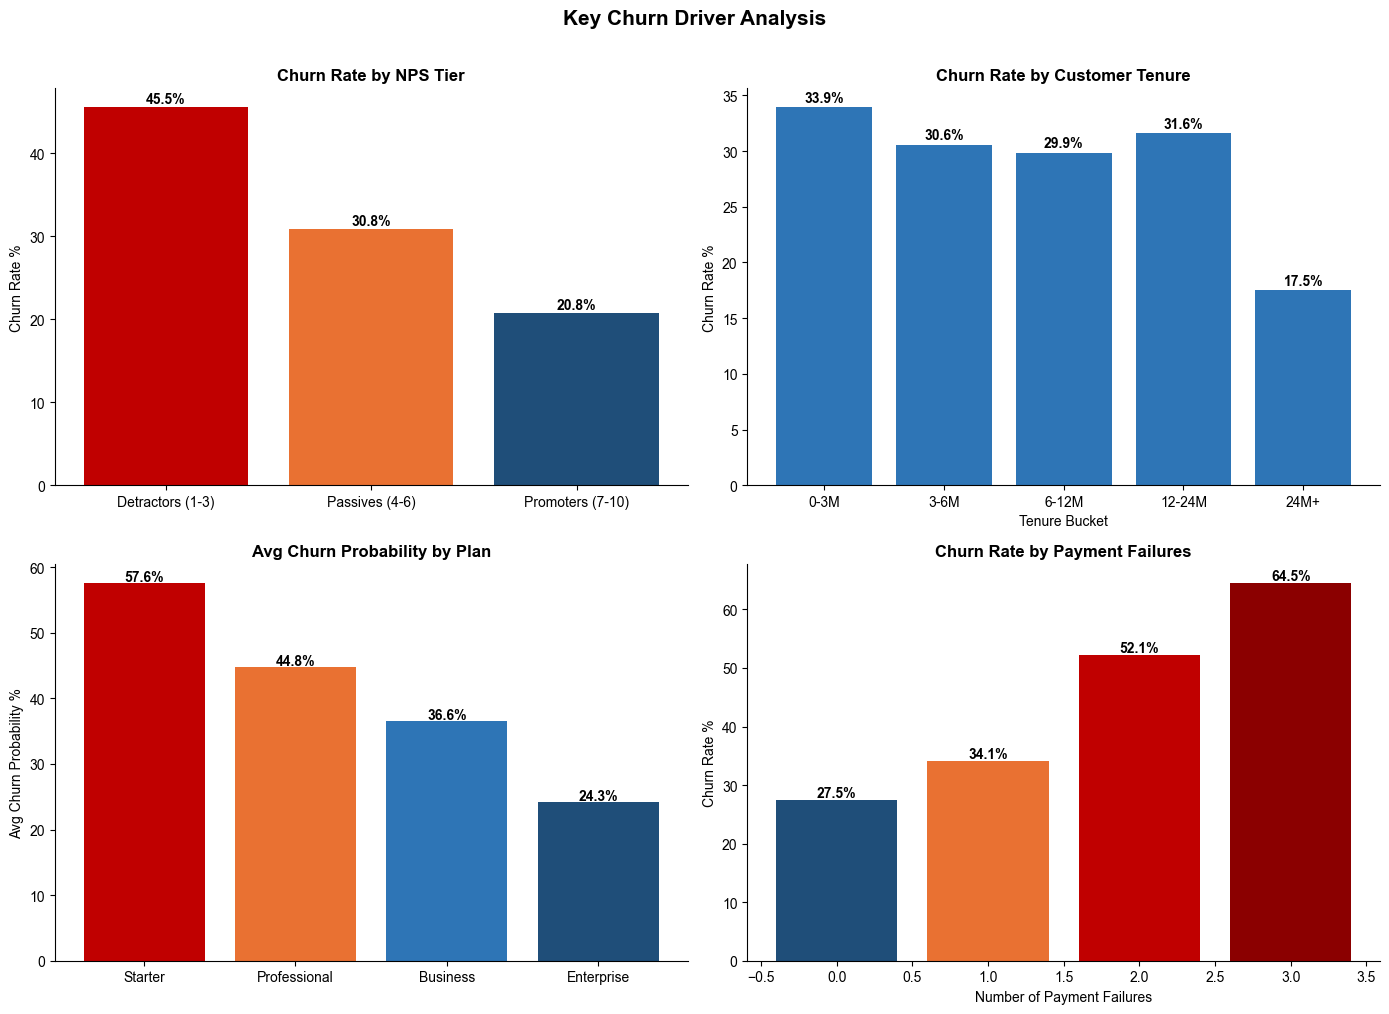

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Churn rate by NPS tier
df['NPS_Tier'] = pd.cut(df['NPS_Score'], bins=[0,3,6,10],
                         labels=['Detractors (1-3)', 'Passives (4-6)', 'Promoters (7-10)'])
nps_churn = df.groupby('NPS_Tier')['Churned'].mean() * 100
bars = axes[0,0].bar(nps_churn.index, nps_churn.values,
                     color=['#C00000', '#E97132', '#1F4E79'])
for bar, val in zip(bars, nps_churn.values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, val + 0.5,
                  f'{val:.1f}%', ha='center', fontweight='bold')
axes[0,0].set_title('Churn Rate by NPS Tier', fontweight='bold')
axes[0,0].set_ylabel('Churn Rate %')

# Churn rate by tenure bucket
df['Tenure_Bucket'] = pd.cut(df['Tenure_Months'],
                              bins=[0,3,6,12,24,100],
                              labels=['0-3M', '3-6M', '6-12M', '12-24M', '24M+'])
tenure_churn = df.groupby('Tenure_Bucket')['Churned'].mean() * 100
axes[0,1].bar(tenure_churn.index, tenure_churn.values, color='#2E75B6')
for i, val in enumerate(tenure_churn.values):
    axes[0,1].text(i, val + 0.5, f'{val:.1f}%', ha='center', fontweight='bold')
axes[0,1].set_title('Churn Rate by Customer Tenure', fontweight='bold')
axes[0,1].set_ylabel('Churn Rate %')
axes[0,1].set_xlabel('Tenure Bucket')

# Avg churn probability by plan
prob_by_plan = df.groupby('Plan')['Churn_Probability'].mean() * 100
plan_order = ['Starter', 'Professional', 'Business', 'Enterprise']
prob_by_plan = prob_by_plan.reindex(plan_order)
bars = axes[1,0].bar(prob_by_plan.index, prob_by_plan.values,
                     color=['#C00000', '#E97132', '#2E75B6', '#1F4E79'])
for bar, val in zip(bars, prob_by_plan.values):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, val + 0.3,
                  f'{val:.1f}%', ha='center', fontweight='bold')
axes[1,0].set_title('Avg Churn Probability by Plan', fontweight='bold')
axes[1,0].set_ylabel('Avg Churn Probability %')

# Payment failures vs churn
payment_churn = df.groupby('Payment_Failures')['Churned'].mean() * 100
axes[1,1].bar(payment_churn.index, payment_churn.values,
              color=['#1F4E79', '#E97132', '#C00000', '#8B0000'])
for i, val in enumerate(payment_churn.values):
    axes[1,1].text(i, val + 0.5, f'{val:.1f}%', ha='center', fontweight='bold')
axes[1,1].set_title('Churn Rate by Payment Failures', fontweight='bold')
axes[1,1].set_ylabel('Churn Rate %')
axes[1,1].set_xlabel('Number of Payment Failures')

plt.suptitle('Key Churn Driver Analysis', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('chart8_churn_drivers.png', dpi=150, bbox_inches='tight')
plt.show()

High risk customer list for CRM:

In [61]:
# Final actionable list for customer success team
high_risk_customers = df[df['Risk_Tier'] == 'High Risk'][[
    'Customer_ID', 'Plan', 'Contract_Type', 'Industry',
    'Monthly_Spend_USD', 'Tenure_Months', 'Logins_Per_Month',
    'Days_Since_Last_Login', 'NPS_Score', 'Payment_Failures',
    'Churn_Probability', 'Risk_Tier'
]].sort_values('Churn_Probability', ascending=False)

print(f"=== HIGH RISK CUSTOMER LIST FOR CRM ===")
print(f"Total high risk customers: {len(high_risk_customers):,}")
print(f"Combined monthly spend at risk: ${high_risk_customers['Monthly_Spend_USD'].sum():,.0f}")
print(f"\nTop 15 highest priority customers:")
display(high_risk_customers.head(15))

high_risk_customers.to_excel('high_risk_customers_crm.xlsx', index=False)
print("\nHigh risk customer list exported for CRM team")

=== HIGH RISK CUSTOMER LIST FOR CRM ===
Total high risk customers: 1,531
Combined monthly spend at risk: $155,663

Top 15 highest priority customers:


,Customer_ID,Plan,Contract_Type,Industry,Monthly_Spend_USD,Tenure_Months,Logins_Per_Month,Days_Since_Last_Login,NPS_Score,Payment_Failures,Churn_Probability,Risk_Tier
1427,CUST-01428,Starter,Monthly,Healthcare,26.78,2,10,46,1,2,0.993500,High Risk
947,CUST-00948,Starter,Monthly,Marketing,32.03,6,12,112,3,2,0.992160,High Risk
2740,CUST-02741,Starter,Monthly,Marketing,26.84,3,20,85,3,1,0.989363,High Risk
3181,CUST-03182,Starter,Monthly,Manufacturing,34.35,7,27,51,4,3,0.988058,High Risk
4416,CUST-04417,Professional,Monthly,Technology,124.79,16,24,58,3,3,0.986767,High Risk
382,CUST-00383,Professional,Monthly,Manufacturing,103.17,1,21,59,1,3,0.984431,High Risk
2924,CUST-02925,Professional,Monthly,Marketing,97.72,12,22,59,2,3,0.982173,High Risk
1675,CUST-01676,Starter,Monthly,Retail,29.95,3,17,28,2,2,0.975470,High Risk
4912,CUST-04913,Starter,Monthly,Marketing,31.77,9,20,47,4,3,0.974926,High Risk
4675,CUST-04676,Professional,Annual,Healthcare,115.99,8,7,23,1,3,0.973881,High Risk



High risk customer list exported for CRM team


## Project Summary

### What I Built
An end-to-end SaaS customer churn prediction system using Python and machine learning.

### Model Performance
- Algorithm: Logistic Regression + Random Forest (comparison)
- Accuracy: 72.8%
- AUC-ROC: 0.821 (industry benchmark: 0.75+)
- Business interpretation: Model correctly identifies churners 82% of the time

### Key Findings
1. Starter plan customers churn at 42.7% vs Enterprise at 13.2% — upgrade path is a retention lever
2. Monthly contract customers churn at 43% vs Two-Year at 13.5% — annual incentives are critical
3. Customers with NPS score 1-3 churn at 60%+ — NPS is an early warning signal
4. Days since last login and logins per month are the strongest behavioral churn predictors
5. Price (28%) and competition (25%) are top churn reasons — pricing strategy needs review

### Business Impact
- $1.87M annual revenue at risk from High Risk customers alone
- 1,560 customers flagged as High Risk for immediate CRM outreach
- Retaining just 20% of High Risk customers = $373K annual saving
- Scored customer list delivered to marketing and customer success teams

### Recommended Actions
1. IMMEDIATE: Personal outreach to top 100 highest-probability churners
2. SHORT TERM: Introduce annual plan incentives for monthly contract customers
3. MEDIUM TERM: Build NPS alert system — trigger retention workflow when score drops below 5
4. ONGOING: Re-run model monthly as new customer data comes in